## Libraries

In [60]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import tensorflow as tf

## Part 1: Importing the data, preprocessing

- Definition of functions

class Preprocessor(object):
    - def __init__():
    - def concatenate_dataset():
    - def showsample():
    - def splitcustom():
    - def process_rgb():
    - def process_gray():
    - def process_scale():
    
- RGB dataset importation and preprocessing

- Roughness dataset importation and preprocessing

- Scale / depth dataset importaiton and preprocessing

In [61]:
class Preprocessor(object):
    # A class that can merge separate datasets, do some image processing and show examples visually
    def __init__(self, title):
        # Initialization
        self.title = title
        print('Initialized: ', title)
    
    def concatenate_dataset(self, paths, grayscale=False):
        # Imports and merges datasets from a list of paths
        u, v = [], []        
        for path in paths:
            with np.load(path) as render_data:
                dico_renders = dict(render_data.items())
            # Images
            imgs = dico_renders['renders']
            imgs[imgs>1.0] = 1.0
            imgs[imgs<0.0] = 0.0
            u.append(imgs)
            # Labels
            labels = dico_renders['labels']
            v.append(labels)
            
        # Images
        imgs_ = np.zeros(u[0][:1].shape)
        for a in u:
            imgs_ = np.concatenate((imgs_, a))
        imgs_ = np.delete(imgs_, 0, 0)
        
        # Labels
        labels_ = np.zeros(v[0][:1].shape)
        for a in v:
            labels_ = np.concatenate((labels_, a))
        labels_ = np.delete(labels_, 0, 0)
        
        print(' ...\n\n=> Loaded dataset of {} entries (resol. {} x {} px). Labels are {}-dimensional.\n'.format(imgs_.shape[0], 
                                                                                                                 imgs_.shape[1], 
                                                                                                                 imgs_.shape[2], 
                                                                                                                 labels_.shape[1]))
        # Show the imported images
        print('Raw images: ')
        self.showsample(imgs_, grayscale=grayscale, labels=labels_)
        
        return imgs_, labels_   
    
    def showsample(self, imgs, grayscale=False, labels=np.array([])):
        # Shows four example images
        fig = plt.figure(figsize=(16,8))
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        for k, img in enumerate(imgs[:4]):
            ax = fig.add_subplot(1,4,k+1)
            # Show labels (optional)
            if (labels.shape[0]>0):
                ax.set_title('RGB: ({:.2f}, {:.2f}, {:.2f})\nRSD: ({:.2f}, {:.0f}, {:.2f})'.format(labels[k,0],
                                                                                                   labels[k,1],
                                                                                                   labels[k,2],
                                                                                                   labels[k,3], 
                                                                                                   labels[k,4], 
                                                                                                   labels[k,5]), loc='left')
            
            # Grayscale (optional)
            if (grayscale):
                ax.imshow(img, cmap=plt.cm.gray)
            else:
                ax.imshow(img)
            
            # Hide axes
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        plt.show()
        
    def split_custom(self, imgs, labels, trs=0.8):
        # Splits the data into training/validation/test sets
        x_tr_, x_val_, y_tr_, y_val_ = train_test_split(imgs, labels, train_size=trs, test_size=1-trs, random_state=0)
        x_val_, x_te_, y_val_, y_te_ = train_test_split(x_val_, y_val_, train_size=0.5, test_size=0.5, random_state=0)

        print('Training / Validation / Test sets sizes: {} / {} / {}'.format(x_tr_.shape[0], x_val_.shape[0], x_te_.shape[0]))

        return x_tr_, y_tr_, x_val_, y_val_, x_te_, y_te_
    
    def process_rgb(self, imgs, radius=0.2):
        # Returns a "blurry" version of the input images by using a FFT filter
        imgs_processed = []
        t0 = time.time()
        for img in imgs:
            reconstruct_inner = []
            for k in range(3):
                # Select channel
                channel = img[:,:,k]
                fftimg = np.fft.fft2(channel)        
                fftimg = np.fft.fftshift(fftimg)
                #print('color: ',np.min(fftimg))
                fft = np.abs(np.log(fftimg))
                # Filter
                locx = int(0.5*img.shape[0])
                locy = int(0.5*img.shape[1])
                r = int(radius*img.shape[0])
                x, y = np.ogrid[:img.shape[0], :img.shape[1]]
                d = ((x-locx)**2 + (y-locy)**2)**0.5
                # Inner image
                fft_in = fftimg.copy()
                fft_in[d>r] = 0
                img_in = np.fft.ifft2(fft_in)
                img_in = np.abs(img_in)
                img_in[img_in>1.0] = 1.0
                img_in[img_in<0.0] = 0.0
                reconstruct_inner.append(img_in)    
            # Reconstruction
            reconstruct_inner = np.asarray(reconstruct_inner)
            reconstruct_inner = np.transpose(reconstruct_inner, (1,2,0))
            imgs_processed.append(reconstruct_inner)
            
        imgs_processed = np.asarray(imgs_processed)
        print('FFT color filter (image processing time: {:.0f} sec.):'.format(time.time()-t0))
        
        self.showsample(imgs_processed, grayscale=False)
        
        return imgs_processed
        
    def process_gray(self, imgs, radius=0.2):
        # Same as process_rgb(self) but for grayscale images (single-channel)
        imgs_processed = []
        t0 = time.time()
        for img in imgs:
            fftimg = np.fft.fft2(img)        
            fftimg = np.fft.fftshift(fftimg)
            fft = np.abs(np.log(fftimg))
            # Filter
            locx = int(0.5*img.shape[0])
            locy = int(0.5*img.shape[1])
            r = int(radius*img.shape[0])
            x, y = np.ogrid[:img.shape[0], :img.shape[1]]
            d = ((x-locx)**2 + (y-locy)**2)**0.5
            # Inner image
            fft_in = fftimg.copy()
            fft_in[d>r] = 0
            img_in = np.fft.ifft2(fft_in)
            img_in = np.abs(img_in)
            img_in[img_in>1.0] = 1.0
            img_in[img_in<0.0] = 0.0
            
            imgs_processed.append(img_in)
            
        imgs_processed = np.asarray(imgs_processed)
        print('FFT grayscale filter (image processing time: {:.0f} sec.):'.format(time.time()-t0))
        
        self.showsample(imgs_processed, grayscale=True)
        
        return imgs_processed
        
    def process_scale(self, imgs, binarize=False, approach='fold_average'):
        # Various options of image processing for scale analysis
        rx, ry = imgs.shape[1], imgs.shape[2]
        t0 = time.time()
        
        # 1) Choose to binarizes the image
        imgs_ = []
        if (binarize==True):
            
            for img in imgs:
                img[img<0.5] = 0.0
                img[img>0.5] = 1.0
                imgs_.append(img)
        elif (binarize==False):
            imgs_ = imgs
        
        # 2) Choose which FFT method to use
        imgs_processed = []
        if (approach=='fft_only'):
            # Returns the whole FFT image (same resolution as the input image)
            for img in imgs_:
                # Compute FFT
                img = np.fft.fft2(img)
                img = np.fft.fftshift(img)
                img = np.abs(np.log(img))
                
                imgs_processed.append(img)
                
        elif (approach=='fold_quarter'):
            # Returns the upper-left corner of the FFT image (using symmetry, reduces dimentionality of the image while keeping the same information)
            for img in imgs_:
                # Compute FFT
                img = np.fft.fft2(img)
                img = np.fft.fftshift(img)
                img = np.abs(np.log(img))
                fft_fold = img[:int(rx/2), :int(ry/2)]
                
                imgs_processed.append(fft_fold)
                
        elif (approach=='fold_average'):
            # Same as "fold_quarter" but where each pixel is an average of four pixels in corresponding positions in the FFT corners
            for img in imgs_:
                # Compute FFT
                img = np.fft.fft2(img)
                img = np.fft.fftshift(img)
                img = np.abs(np.log(img))
                fft_fold = np.zeros((int(rx/2), int(ry/2)))
                for i in range(int(rx/2)):
                    for j in range(int(ry/2)):
                        fft_fold[i,j] = np.mean((img[i,j], img[i,rx-j-2], img[ry-i-2,j], img[ry-i-2,rx-j-2]))
                
                imgs_processed.append(fft_fold)

        elif (approach=='no_fft'):
            # Doesn't do anything
            imgs_processed = imgs_
              
        else:
            print('Unknown approach.')
                       
        imgs_processed = np.asarray(imgs_processed)
        
        print('Raw FFT (image processing time: {:.0f} sec.):'.format(time.time()-t0))
        self.showsample(imgs_processed, grayscale=True)
        
        return imgs_processed

### RGB dataset importation and preprocessing

Initialized:  rgb
 ...

=> Loaded dataset of 500 entries (resol. 128 x 128 px). Labels are 6-dimensional.

Raw images: 


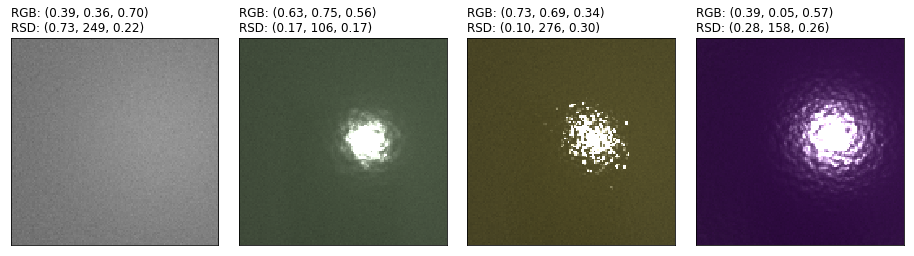

FFT color filter (image processing time: 5 sec.):


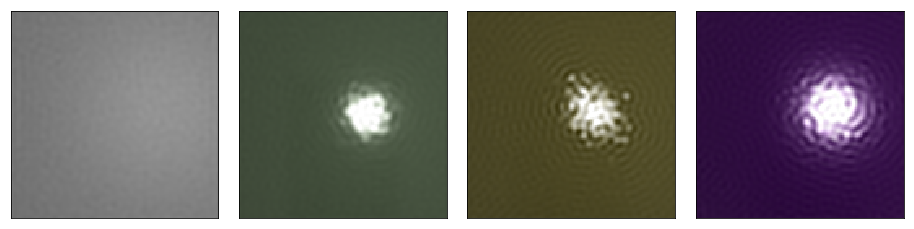

Training / Validation / Test sets sizes: 400 / 50 / 50


In [62]:
# Importation
preproc = Preprocessor('rgb')
imgs, labels = preproc.concatenate_dataset(paths=['./datasets/rgb/render_dataset_color_r128_s128_n500_rot005.npz'], grayscale=False)

# Image processing (reduces the number of components in PCA)
imgs_processed = preproc.process_rgb(imgs, radius=0.2)

# Splitting
x_tr, y_tr, x_val, y_val, x_te, y_te = preproc.split_custom(imgs_processed, labels)

### Roughness dataset importation and preprocessing

Initialized:  roughness-depth
 ...

=> Loaded dataset of 2000 entries (resol. 128 x 128 px). Labels are 6-dimensional.

Raw images: 


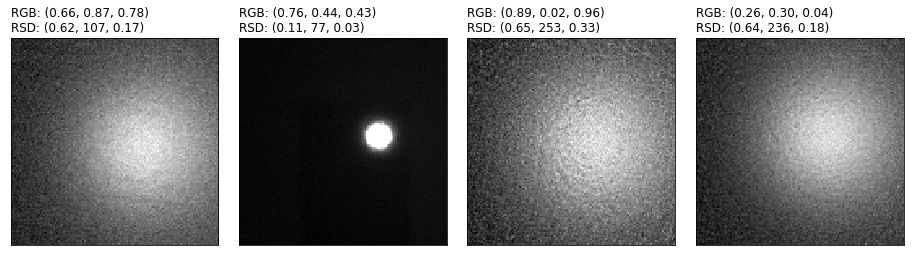

FFT grayscale filter (image processing time: 6 sec.):


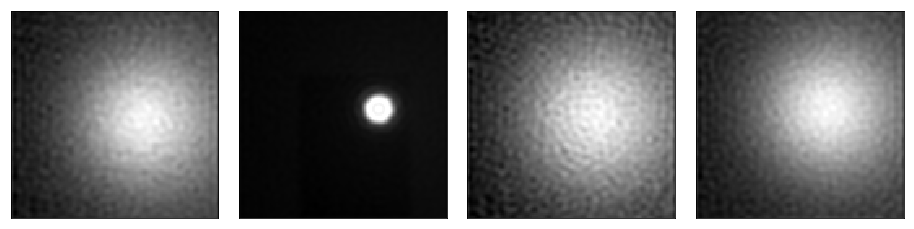

Training / Validation / Test sets sizes: 1600 / 200 / 200


In [63]:
# Importation
preproc = Preprocessor('roughness-depth')
imgs, labels = preproc.concatenate_dataset(paths=['./datasets/roughness/render_dataset_gray_r128_s128_n2000_rot005.npz'], grayscale=True)

# Image processing (this reduces the number of components in PCA)
imgs_processed = preproc.process_gray(imgs, radius=0.2)

# Splitting
x_tr_gray, y_tr_gray, x_val_gray, y_val_gray, x_te_gray, y_te_gray = preproc.split_custom(imgs_processed, labels)

### Scale / depth dataset importation and preprocessing

Initialized:  scale
 ...

=> Loaded dataset of 10000 entries (resol. 128 x 128 px). Labels are 6-dimensional.

Raw images: 


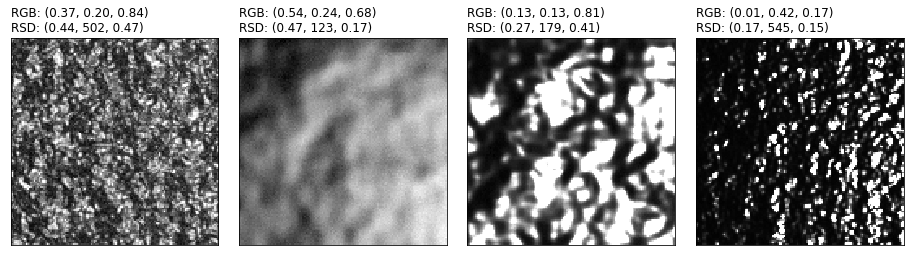

Raw FFT (image processing time: 18 sec.):


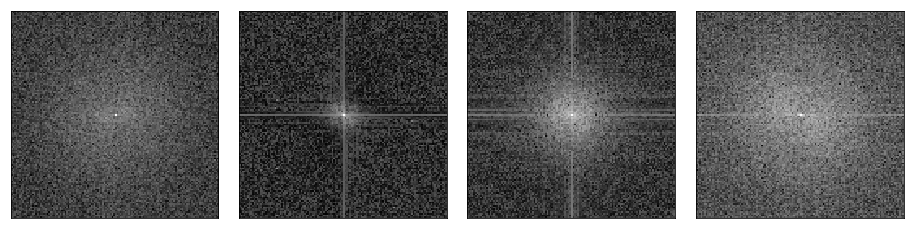

Training / Validation / Test sets sizes: 8000 / 1000 / 1000


In [76]:
# Importation
preproc = Preprocessor('scale')
imgs, labels = preproc.concatenate_dataset(paths=['./datasets/scale/render_dataset_scale_r128_s96_n2000_rot005_01.npz',
                                                  './datasets/scale/render_dataset_scale_r128_s96_n2000_rot005_02.npz',
                                                  './datasets/scale/render_dataset_scale_r128_s96_n2000_rot005_03.npz',
                                                  './datasets/scale/render_dataset_scale_r128_s96_n2000_rot005_04.npz',
                                                  './datasets/scale/render_dataset_scale_r128_s96_n2000_rot005_05.npz'
                                                ], grayscale=True)
                                                
# Image processing
imgs_processed = preproc.process_scale(imgs, binarize=False, approach='fft_only')

# Splitting
x_tr_scale, y_tr_scale, x_val_scale, y_val_scale, x_te_scale, y_te_scale = preproc.split_custom(imgs_processed, labels)

## Part 2: Classical machine learning approach

- Definition of functions
class Fitter(object):
    - def __init__():
    - def plot_pca():
    - def RMSE():
    - def MAE():
    - def optimize_regression()
    
- RGB regression optimization
- Roughess regression optimization
- Texture depth regression optimization
- Texture scale regression optimization

In [65]:
class Fitter(object):
    # A class that can perform PCA on a dataset, test various classical ML technique and identify the best technique with ideal parameters
    def __init__(self, title, y_tr_, y_val_, x_tr_, x_val_, limdown_, limup_, y_te_, x_te_):
        # Initializes variables
        self.title = title
        self.y_tr_ = y_tr_
        self.y_val_ = y_val_
        self.x_tr_ = x_tr_
        self.x_val_ = x_val_
        self.limdown_ = limdown_
        self.limup_ = limup_
        self.y_te_ = y_te_
        self.x_te_ = x_te_
        self.fil_ = None
        
    def plot_pca(self, num=300, thresh=0.99, tp=10):
        # Runs PCA, plots explained variance and makes a 2D plot
        pca = PCA(n_components=None)
        pca.fit(self.x_tr_)
        pve = pca.explained_variance_ratio_
        pve_cumsum = np.cumsum(pve)
        pve_small = pve[:tp]
        pve_cumsum_small = pve_cumsum[:tp]
        xcor = np.arange(1, len(pve)+1)
        xcor_small = np.arange(1, len(pve_cumsum_small)+1)
        
        print('\n=> PCA analysis:\n')
        fig = plt.figure(figsize=(16,5))
        ax1 = fig.add_subplot(121)
        ax1.set_title('First {} components ({})'.format(tp, self.title))
        ax1.bar(xcor_small, pve_small, label='independant')
        ax1.set_xticks(xcor_small)
        ax1.step(xcor_small+0.5, pve_cumsum_small, label='cumulative')
        ax1.set_xlabel('Number of components')
        ax1.set_ylabel('Proportion of variance explained')
        ax1.legend(loc=4)

        X_pca = pca.transform(self.x_tr_[:num])

        ax2 = fig.add_subplot(122)
        height = self.y_tr_[:num]
        sc = ax2.scatter(X_pca[:,0], X_pca[:,1], c=height)
        ax2.set_title('2D plot ({})'.format(self.title))
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')
        plt.colorbar(sc, label=self.title)

        plt.show()

        # Number of pca components for [thresh]% of variance explained
        self.fil_ = ~(pve_cumsum > thresh)
        self.fil_ = self.fil_.sum()
        
        print('Results: {:.0f}% of the variance is found within the first {:.0f} components.\n'.format(100*thresh, self.fil_))
        
    def RMSE(self, y, y_pred):
        # Returns the root mean squared error
        return np.sqrt(np.mean(np.abs((y-y_pred)**2)))
    
    def MAE(self, y, y_pred):
        # Returns the mean absolute error
        return np.mean(np.abs(y-y_pred))

    def optimize_regression(self, error_metric='RMSE', methods={'Ridge' : {'ridge__alpha':[0.01, 0.1, 1, 10, 100]}, 
                                                                'KNN'   : {'knn__n_neighbors':[2, 5, 10],
                                                                           'knn__weights':['uniform', 'distance']},
                                                                'SVR'   : {'svr__C':[0.01, 0.1, 1, 10, 100, 1000],},
                                                                'DT'    : {'dt__max_depth':[2, 4, 6, 8, 10]}}):
        
        # Tests the ML techniques specified in argument "methods" with specified parameters. 
        # Compares together best results of each method and identifies the best method.
        
        performance, predictions_test_set = {}, {}

        for method in list(methods.keys()):
            # Defines a grid
            grid = ParameterGrid(methods[method])
            # Ridge linear regressions
            if (method=='Ridge'):
                pipe = Pipeline([
                    ('pca', PCA(n_components=self.fil_)),
                    ('ridge', Ridge())])
            # K-Nearest neighbours
            elif (method=='KNN'):
                pipe = Pipeline([
                    ('pca', PCA(n_components=self.fil_)),
                    ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])
            # Support vector regressions
            elif (method=='SVR'):
                pipe = Pipeline([
                    ('pca', PCA(n_components=self.fil_)),
                    ('svr', SVR(tol=1e-3,
                                max_iter=1e4))])
            # Decision trees
            elif (method=='DT'):
                pipe = Pipeline([
                    ('pca', PCA(n_components=self.fil_)),
                    ('dt', DecisionTreeRegressor(random_state=0))])
            # Unknown
            else:
                print('Unknown method')

            # Iterate through parameters of the method    
            best_mae = 1e9
            for params in grid:
                # Set parameters
                pipe.set_params(**params)
                # Fit the model
                t0 = time.time()
                pipe.fit(self.x_tr_, self.y_tr_)
                t1 = time.time() - t0
                # Compute predictions on validation set
                pred_val = pipe.predict(self.x_val_)
                # With limits
                pred_val[pred_val<self.limdown_] = self.limdown_
                pred_val[pred_val>self.limup_] = self.limup_
                # Evaluate the error
                if (error_metric=='RMSE'):
                    mae_val = self.RMSE(self.y_val_, pred_val)
                elif (error_metric=='MAE'):
                    mae_val = self.MAE(self.y_val_, pred_val)
                # Keep best parameters and corresponding fitting time / error
                if (mae_val < best_mae):
                    best_params = params
                    best_time = t1
                    best_mae = mae_val

            # Set best parameters found, compute predictions on the test set and evaluate the error
            pipe.set_params(**best_params)
            pred_test = pipe.predict(self.x_te_)
            if (error_metric=='RMSE'):
                mae_test = self.RMSE(self.y_te_, pred_test)
            elif (error_metric=='MAE'):
                mae_test = self.MAE(self.y_te_, pred_test)

            # Store characteristics of the method (ML technique)
            performance[method] = [pipe, best_params, best_time, best_mae, mae_test]
            
            # Store predictions on the test set
            predictions_test_set[method] = pred_test
        
        # Compute baseline performance
        if (error_metric=='RMSE'):
            base_mse_ = self.RMSE(self.y_te_, np.mean(self.y_tr_))
        elif (error_metric=='MAE'):
            base_mse_ = self.MAE(self.y_te_, np.mean(self.y_tr_))
        performance['Baseline'] = [np.nan, np.nan, np.nan, base_mse_, base_mse_]
        
        # Put everything in a dataframe for easier sorting/plotting/selection
        df_perf = pd.DataFrame(performance).transpose()
        df_perf.columns = ['best_estimator', 'best_parameters', 'fitting_time', 'validation_set', 'test_set']
        print('\n=> Regression optimization:\n')
        
        # Bar plot, to compare performance of the methods
        fig = plt.figure(figsize=(16,5))
        ax0 = fig.add_subplot(121)
        dfs = df_perf[['validation_set', 'test_set']].sort_values(by='test_set')
        dfs.plot.bar(ax=ax0)
        ax0.set_title(self.title)
        ax0.set_ylabel(error_metric)
        
        # Identify best method, make sure it is not baseline
        best_method = dfs.index[0]
        if (best_method=='Baseline'):
            best_method = dfs.index[1]
        
        # Store characteristics of the best estimator
        best_estimator = df_perf.loc[best_method,'best_estimator']
        best_method_params = df_perf.loc[best_method,'best_parameters']
        best_method_mae_val = df_perf.loc[best_method,'validation_set']
        best_method_mae_test = df_perf.loc[best_method,'test_set']

        # Plot predictions of the best estimator as compared to test set values
        df = pd.DataFrame(data={'test_values':self.y_te_, 'fit':predictions_test_set[best_method]})
        df = df.sort_values(by='test_values', ascending=False)
        ax = fig.add_subplot(122)
        ax.set_title('{} predictions ({} model)'.format(self.title, best_method))
        ax.plot(np.arange(0,self.x_te_.shape[0]), df['test_values'], marker='', color='black', label='Test values')
        ax.plot(np.arange(0,self.x_te_.shape[0]), df['fit'], marker='', label='{} model'.format(best_method))
        ax.get_xaxis().set_visible(False)
        ax.set_xlim(0,self.x_te_.shape[0]-1)
        ax.set_ylim(0,self.y_te_.max()*1.2)
        ax.legend(loc=1)
        plt.show()
        
        # Display fitting time
        print('=> Fitting times (sec):\n')
        print(df_perf['fitting_time'].astype(float).round(2))
        
        # Display characteristics of the best estimator
        print('\n=> Suggested method:\n')
        print('{} with parameters {}\n{} on validation set: {:.3f}\n{} on test set: {:.3f}'.format(best_method, 
                                                                                                   best_method_params,
                                                                                                   error_metric,
                                                                                                   best_method_mae_val,
                                                                                                   error_metric,
                                                                                                   best_method_mae_test))
        
        return [best_estimator, best_method, best_method_params, best_method_mae_val, best_method_mae_test]

In [66]:
# Dictionary to collect all results
runfit = {}

# Flatten function
def flatten(array):
    return array.reshape(array.shape[0], array.shape[1]*array.shape[2])

### RGB regression optimization


=> PCA analysis:



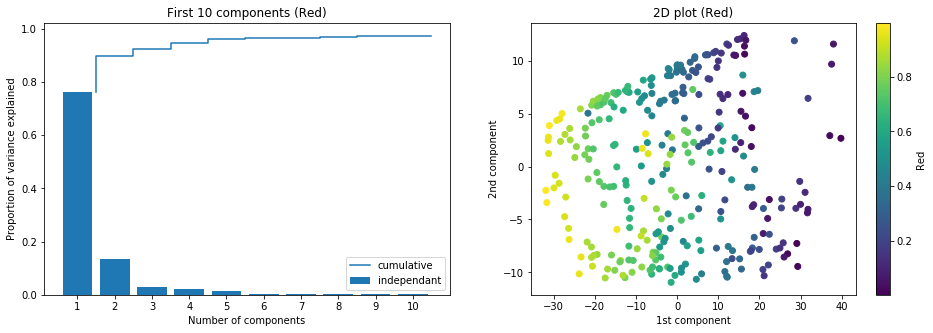

Results: 99% of the variance is found within the first 49 components.


=> Regression optimization:



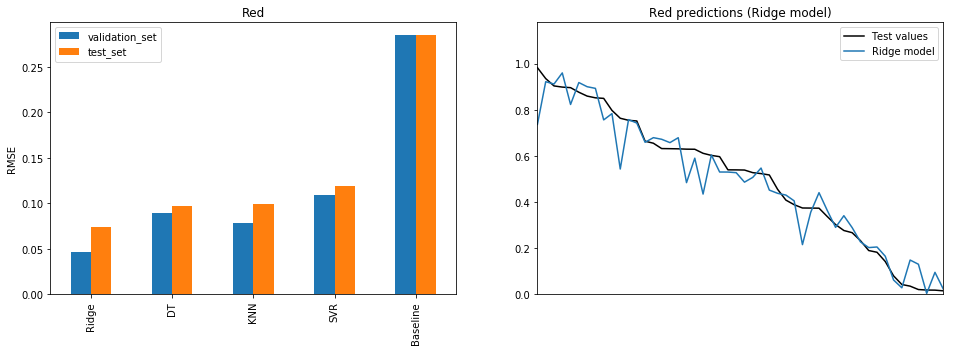

=> Fitting times (sec):

Baseline     NaN
DT          0.45
KNN         0.44
Ridge       0.46
SVR         0.48
Name: fitting_time, dtype: float64

=> Suggested method:

Ridge with parameters {'ridge__alpha': 1}
RMSE on validation set: 0.047
RMSE on test set: 0.074

=> PCA analysis:



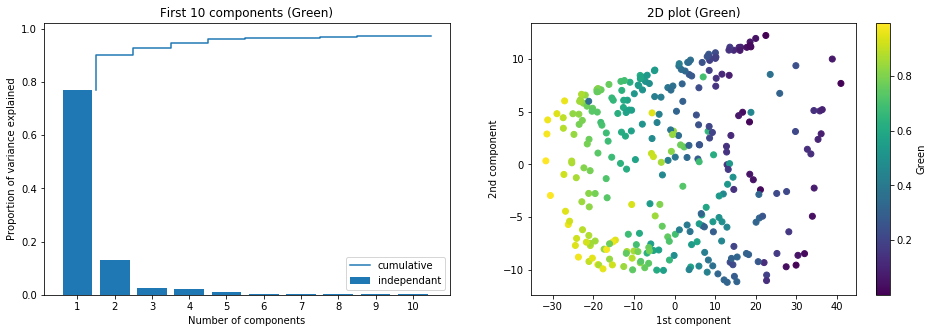

Results: 99% of the variance is found within the first 48 components.


=> Regression optimization:



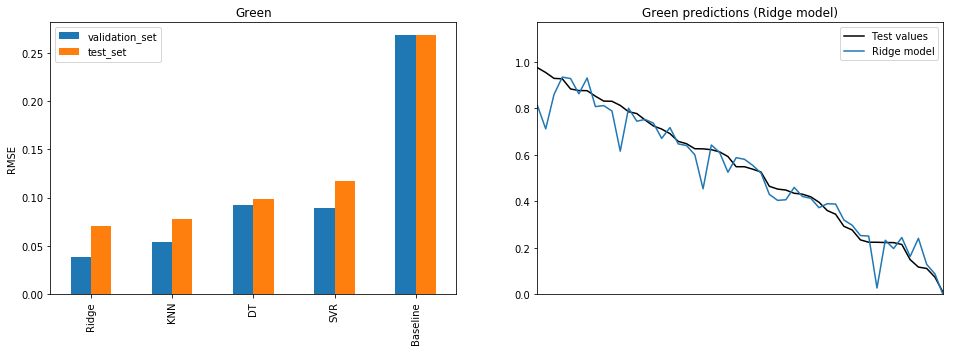

=> Fitting times (sec):

Baseline     NaN
DT          0.45
KNN         0.46
Ridge       0.44
SVR         0.49
Name: fitting_time, dtype: float64

=> Suggested method:

Ridge with parameters {'ridge__alpha': 10}
RMSE on validation set: 0.038
RMSE on test set: 0.070

=> PCA analysis:



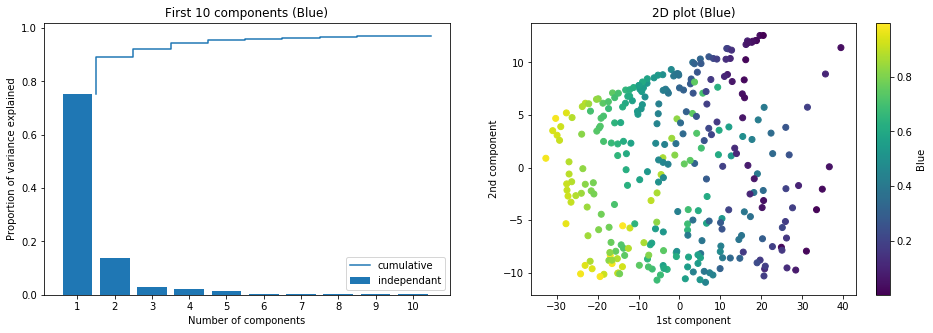

Results: 99% of the variance is found within the first 51 components.


=> Regression optimization:



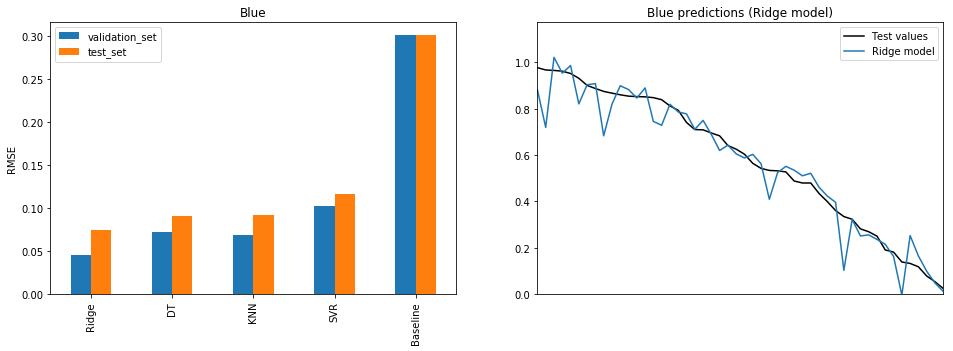

=> Fitting times (sec):

Baseline     NaN
DT          0.46
KNN         0.46
Ridge       0.45
SVR         0.45
Name: fitting_time, dtype: float64

=> Suggested method:

Ridge with parameters {'ridge__alpha': 10}
RMSE on validation set: 0.046
RMSE on test set: 0.075


In [67]:
# RED CHANNEL
redfit = Fitter('Red', 
                y_tr[:,0], 
                y_val[:,0], 
                flatten(x_tr[:,:,:,0]), 
                flatten(x_val[:,:,:,0]), 
                0, 1, 
                y_te[:,0], 
                flatten(x_te[:,:,:,0]))

# PCA
redfit.plot_pca()

# Optimization
runfit['Red'] = redfit.optimize_regression()

# GREEN CHANNEL
greenfit = Fitter('Green', 
                  y_tr[:,1], 
                  y_val[:,1], 
                  flatten(x_tr[:,:,:,1]), 
                  flatten(x_val[:,:,:,1]), 
                  0, 1, 
                  y_te[:,1], 
                  flatten(x_te[:,:,:,1]))

# PCA
greenfit.plot_pca()

# Optimization
runfit['Green'] = greenfit.optimize_regression()

# BLUE CHANNEL
bluefit = Fitter('Blue', 
                 y_tr[:,2], 
                 y_val[:,2], 
                 flatten(x_tr[:,:,:,2]), 
                 flatten(x_val[:,:,:,2]), 
                 0, 1, 
                 y_te[:,2], 
                 flatten(x_te[:,:,:,2]))

# PCA
bluefit.plot_pca()

# Optimization
runfit['Blue'] = bluefit.optimize_regression()

In [68]:
# Instead, choose a method that can generalize better

#runfit['Red'] = redfit.optimize_regression(methods={'Ridge':{'ridge__alpha':[100]}})
#runfit['Green'] = greenfit.optimize_regression(methods={'Ridge':{'ridge__alpha':[100]}})
#runfit['Blue'] = bluefit.optimize_regression(methods={'Ridge':{'ridge__alpha':[100]}})

### Roughness regression optimization


=> PCA analysis:



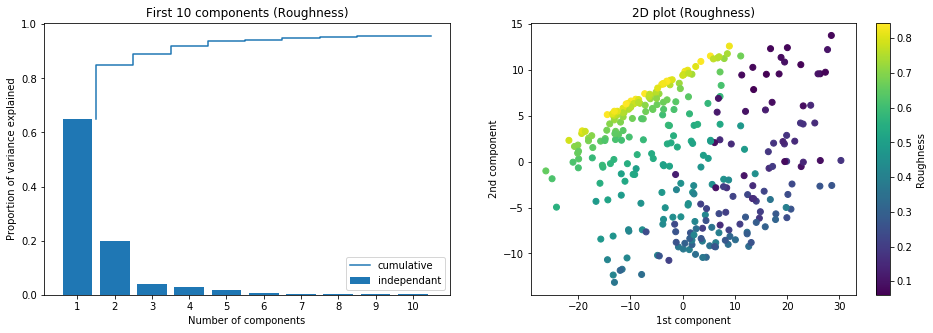

Results: 95% of the variance is found within the first 7 components.


=> Regression optimization:



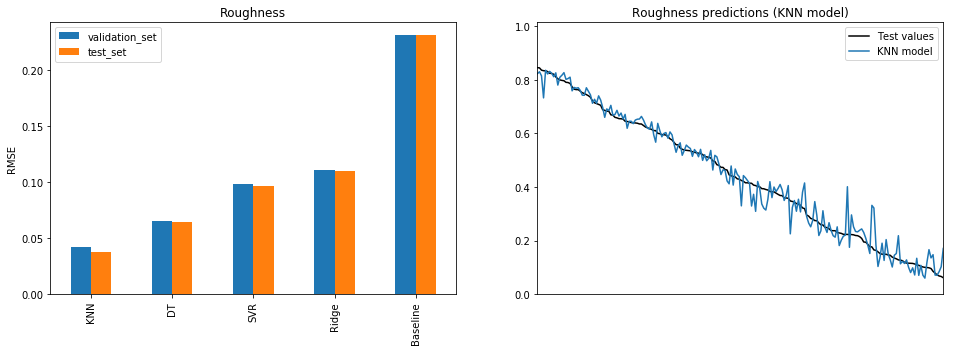

=> Fitting times (sec):

Baseline     NaN
DT          1.77
KNN         1.76
Ridge       1.81
SVR         1.90
Name: fitting_time, dtype: float64

=> Suggested method:

KNN with parameters {'knn__n_neighbors': 2, 'knn__weights': 'distance'}
RMSE on validation set: 0.042
RMSE on test set: 0.038


In [69]:
# Fitter object
roughfit = Fitter('Roughness', 
                  y_tr_gray[:,3], 
                  y_val_gray[:,3], 
                  flatten(x_tr_gray), 
                  flatten(x_val_gray), 
                  0.05, 0.85, 
                  y_te_gray[:,3], 
                  flatten(x_te_gray))

# PCA
roughfit.plot_pca(thresh=0.95)

# Optimization
runfit['Roughness'] = roughfit.optimize_regression()

In [70]:
# Instead, choose a method that can generalize better

#runfit['Roughness'] = roughfit.optimize_regression(methods={'DT':{'dt__max_depth':[5]}})

### Texture depth regression optimization


=> PCA analysis:



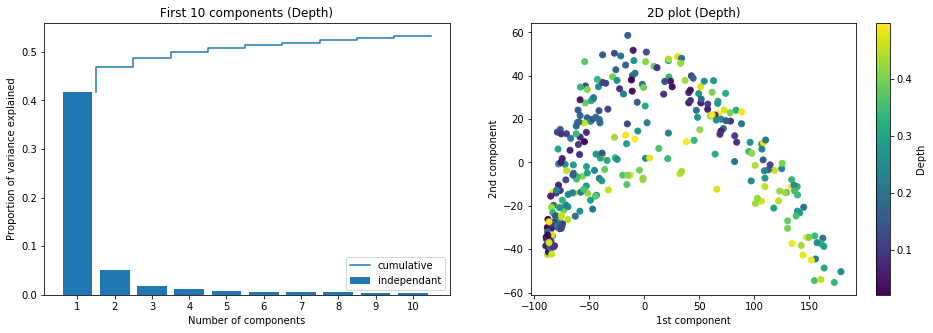

Results: 80% of the variance is found within the first 582 components.


=> Regression optimization:



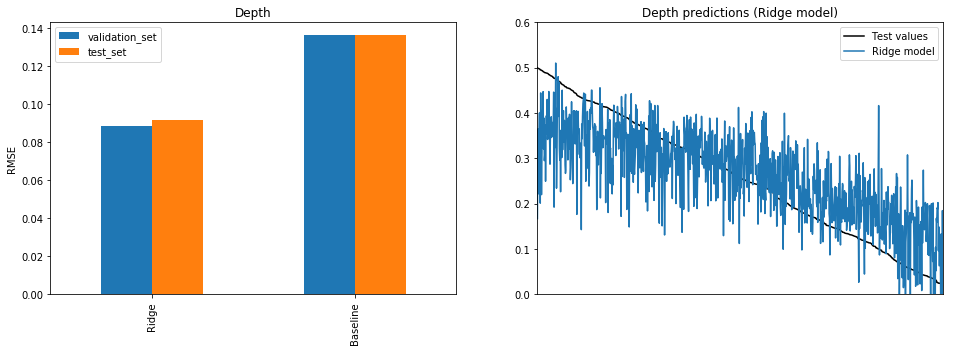

=> Fitting times (sec):

Baseline     NaN
Ridge       6.69
Name: fitting_time, dtype: float64

=> Suggested method:

Ridge with parameters {'ridge__alpha': 10}
RMSE on validation set: 0.089
RMSE on test set: 0.092


In [78]:
subset = 2000
depthfit = Fitter('Depth', 
                  y_tr_scale[:subset,5], 
                  y_val_scale[:subset,5], 
                  flatten(x_tr_scale[:subset]), 
                  flatten(x_val_scale[:subset]), 
                  0.02, 0.5,
                  y_te_scale[:subset,5], 
                  flatten(x_te_scale[:subset]))

# PCA
depthfit.plot_pca(thresh=0.8)

runfit['Depth'] = depthfit.optimize_regression(methods={'Ridge' : {'ridge__alpha':[0.1, 1, 10, 100]}})

In [72]:
# Instead, choose a method that can generalize better

#runfit['Depth'] = depthfit.optimize_regression(methods={'Ridge' : {'ridge__alpha':[100]}})

### Texture scale regression optimization


=> PCA analysis:



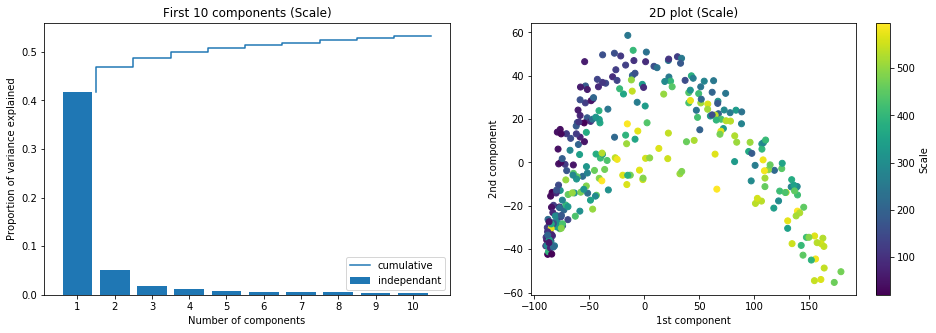

Results: 80% of the variance is found within the first 582 components.


=> Regression optimization:



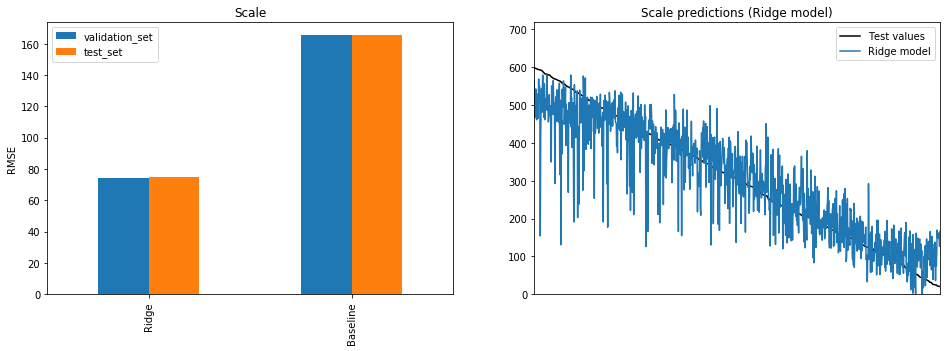

=> Fitting times (sec):

Baseline     NaN
Ridge       6.55
Name: fitting_time, dtype: float64

=> Suggested method:

Ridge with parameters {'ridge__alpha': 10}
RMSE on validation set: 73.956
RMSE on test set: 74.939


In [77]:
subset = 2000
scalefit = Fitter('Scale', 
                  y_tr_scale[:subset,4], 
                  y_val_scale[:subset,4], 
                  flatten(x_tr_scale[:subset]), 
                  flatten(x_val_scale[:subset]), 
                  20, 600, 
                  y_te_scale[:subset,4], 
                  flatten(x_te_scale[:subset]))

# PCA
scalefit.plot_pca(thresh=0.8)

# Optimization
runfit['Scale'] = scalefit.optimize_regression(methods={'Ridge' : {'ridge__alpha':[0.1, 1, 10, 100]}})

In [74]:
# Instead choose a method that can generalize better

#runfit['Scale'] = scalefit.optimize_regression(methods={'Ridge' : {'ridge__alpha':[100]}})

### Summary: classical methods

In [79]:
# The best identified methods so far and associated parameters and errors

df = pd.DataFrame(runfit).transpose()
df.columns = ['estimator', 'method', 'parameters', 'RMSE (validation set)', 'RMSE (test set)']
df

estimator method  \
Blue       Pipeline(memory=None,\n     steps=[('pca', PCA...  Ridge   
Depth      Pipeline(memory=None,\n     steps=[('pca', PCA...  Ridge   
Green      Pipeline(memory=None,\n     steps=[('pca', PCA...  Ridge   
Red        Pipeline(memory=None,\n     steps=[('pca', PCA...  Ridge   
Roughness  Pipeline(memory=None,\n     steps=[('pca', PCA...    KNN   
Scale      Pipeline(memory=None,\n     steps=[('pca', PCA...  Ridge   

                                                  parameters  \
Blue                                    {'ridge__alpha': 10}   
Depth                                   {'ridge__alpha': 10}   
Green                                   {'ridge__alpha': 10}   
Red                                      {'ridge__alpha': 1}   
Roughness  {'knn__n_neighbors': 2, 'knn__weights': 'dista...   
Scale                                   {'ridge__alpha': 10}   

          RMSE (validation set) RMSE (test set)  
Blue                  0.0461526       0.0748259  
Depth                 0.0885808       0.0915049  
Green                 0.0384067       0.0704505  
Red                   0.0467908       0.0740018  
Roughness             0.0424648        0.037951  
Scale                   73.9557         74.9393

## Part 3: CNN approach

class CNN_Graph(object):
    - def __init__():
    - def get_batches():
    - def custom_x_shape():
    - def custom_y_shape():
    - def launchG():
    - def return_prediction():
    
- Roughness CNN
- Texture depth CNN
- Texture scale CNN

In [80]:
class CNN_Graph(object):
    # A class that can build up a graph, run (and save/retreive) a tensorflow session for CNN analysis and compute predictions
    def __init__(self, f1, f2, rx, ry, rz):
        # Creates the graph
        self.rz = rz
        self.graph = tf.Graph()
        
        with self.graph.as_default():
            
            # X/y Placeholders
            self.X = tf.placeholder(dtype=tf.float32, shape=[None, rx, ry, self.rz])
            self.y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
            
            # Convolutional layer 1
            conv1 = tf.layers.conv2d(self.X,
                                      filters=f1,
                                      kernel_size=(5, 5), 
                                      strides=(2, 2),
                                      padding='SAME', 
                                      activation=tf.nn.relu,
                                      kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0),
                                      name='conv_1')
            
            # Pooling layer 1
            pool1 = tf.layers.max_pooling2d(conv1,
                                             pool_size=(2, 2),
                                             strides=(2, 2),
                                             padding='SAME')
            
            # Convolutional layer 2
            conv2 = tf.layers.conv2d(pool1,
                                      filters=f2,
                                      kernel_size=(3, 3), 
                                      strides=(1, 1),
                                      padding='SAME', 
                                      activation=tf.nn.relu,
                                      kernel_initializer = tf.truncated_normal_initializer(stddev=0.01, seed=0),
                                      name='conv_2')
            
            # Pool layer 2
            pool2 = tf.layers.max_pooling2d(conv2,
                                             pool_size=(2, 2),
                                             strides=(2, 2),
                                             padding='SAME')
            
            # Flattened pool
            flat_pool = tf.contrib.layers.flatten(pool2)
            
            # Dropout
            self.dropout = tf.placeholder(dtype=tf.bool)
            flat_pool = tf.layers.dropout(flat_pool, rate=0.5, seed=0, training=self.dropout)
            
            # Hidden layer
            hidden = tf.layers.dense(flat_pool, 4*f2,
                                     activation=tf.nn.relu,
                                     kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
                                     bias_initializer=tf.zeros_initializer(),
                                     name='hidden')
            
            # Logits
            self.logits = tf.layers.dense(hidden, 1,
                                     activation=None,
                                     kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
                                     bias_initializer=tf.zeros_initializer(),
                                     name='logits')

            # Loss function
            self.mse = tf.losses.mean_squared_error(labels=self.y, predictions=self.logits)
        
            # Adam optimizer
            self.lr = tf.placeholder(dtype=tf.float32)
            gd = tf.train.AdamOptimizer(learning_rate=self.lr)

            # Minimize loss function
            self.train_op = gd.minimize(self.mse)
        
            print('Setup graph with {} filters in 1st CL, {} filters in 2nd CL and {} neurons in fully-connected layer.\n'.format(f1, f2, 4*f2))

    def get_batches(self, X, y):
        shuffled_idx = np.arange(len(y))
        np.random.shuffle(shuffled_idx)
        
        for i in range(0, len(y), self.batch_size):
            batch_idx = shuffled_idx[i:i+self.batch_size]
            yield X[batch_idx], y[batch_idx]
    
    def custom_x_shape(self, x_):
        return x_.reshape(x_.shape[0], x_.shape[1], x_.shape[2], self.rz)
    
    def custom_y_shape(self, y_):
        return y_.reshape(y_.shape[0], 1)
    
    def launchG(self, title, epochs, learning_rate, batch_size, x_tr_, y_tr_, x_val_, y_val_, x_te_, y_te_):
        
        x_tr_  = self.custom_x_shape(x_tr_)
        x_val_ = self.custom_x_shape(x_val_)
        x_te_  = self.custom_x_shape(x_te_)
        y_tr_  = self.custom_y_shape(y_tr_)
        y_val_ = self.custom_y_shape(y_val_)
        y_te_  = self.custom_y_shape(y_te_)
        
        self.batch_size = batch_size
        self.title = title
        
        valid_mses, batch_mses = [], []
        t0 = time.time()
        
        with tf.Session(graph=self.graph) as sess:
            
            sess.run(tf.global_variables_initializer())
            np.random.seed(0)
                    
            for epoch in range(epochs):
                for X_batch, y_batch in self.get_batches(x_tr_, y_tr_):
                    _, mse_batch, logits_batch = sess.run([self.train_op, self.mse, self.logits], feed_dict={self.X:X_batch, 
                                                                                                             self.y:y_batch,
                                                                                                             self.lr:learning_rate,
                                                                                                             self.dropout:True})
                    batch_mses.append(mse_batch)
                    
                valid_mse = sess.run(self.mse, feed_dict={self.X:x_val_,
                                                          self.y:y_val_,
                                                          self.dropout:False})
                valid_mses.append(np.sqrt(valid_mse))
                
                print('Finished epoch {}. Validation RMSE = {:.4f}'.format(epoch+1, np.sqrt(valid_mse)))
                      
            # Compute accuracy on test set
            test_mse, test_predictions = sess.run([self.mse, self.logits], feed_dict={self.X:x_te_,
                                                                                      self.y:y_te_,
                                                                                      self.dropout:False})
            
            print('Finished (time: {:.1f} sec).'.format(time.time()-t0))
            
            test_predictions = test_predictions[:,0]
            y_te_ = y_te_[:,0]

            df = pd.DataFrame(data={'test_values':y_te_, 'fit':test_predictions})
            df = df.sort_values(by='test_values', ascending=False)

            fig = plt.figure(figsize=(16,5))
            ax0 = fig.add_subplot(121)
            ax0.plot(np.arange(1,epochs+1,1), valid_mses, marker='o')
            ax0.set_xlim(1,epochs)
            ax0.xaxis.grid(which='major', linestyle='--')
            ax0.set_xticks(np.arange(1,epochs+1,1))
            ax0.set_title('Validation RMSE ({})'.format(title))
            ax0.set_xlabel('Epoch')
            ax0.set_ylabel('RMSE')

            ax1 = fig.add_subplot(122)
            ax1.set_title('Predictions ({})'.format(title))
            ax1.plot(np.arange(len(test_predictions)), df['test_values'], marker='', color='black', label='Test values')
            ax1.plot(np.arange(len(y_te_)), df['fit'], marker='', label='{} fit'.format(title))
            ax1.get_xaxis().set_visible(False)
            ax1.legend(loc=1)

            plt.show()

            print('RMSE on test set: {:.2f}'.format(np.sqrt(test_mse)))

            # Save the variables to disk.
            self.saver = tf.train.Saver()
            save_path = self.saver.save(sess, './cache/cnn_model_{}.ckpt'.format(title))
            print("Model saved in path: %s" % save_path)

            return ['CNN', valid_mses[-1], test_mse]
        
    def return_prediction(self, x_pred_, limdown, limup):
        
        with tf.Session(graph=self.graph) as sess:

            self.saver.restore(sess, './cache/cnn_model_{}.ckpt'.format(self.title))
            print("Model restored.")
            
            predictions = sess.run(self.logits, feed_dict={self.X:x_pred_,
                                                           self.dropout:False})
            predictions = predictions[:,0]
            
            predictions[predictions<limdown] = limdown
            predictions[predictions>limup]   = limup

            return predictions

In [81]:
# To store all CNN results

runfit_cnn = {}

### Roughness CNN

Initialized:  roughness-depth
 ...

=> Loaded dataset of 8000 entries (resol. 128 x 128 px). Labels are 6-dimensional.

Raw images: 


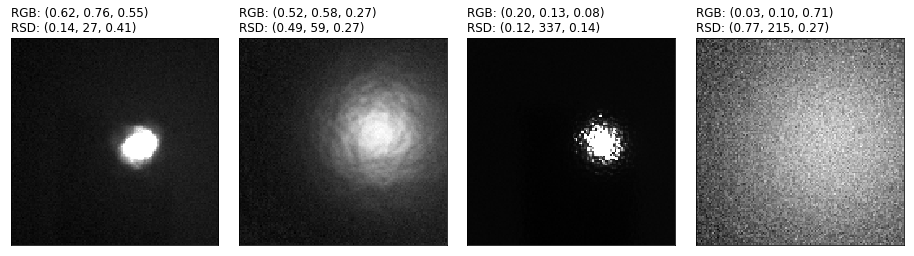

FFT grayscale filter (image processing time: 31 sec.):


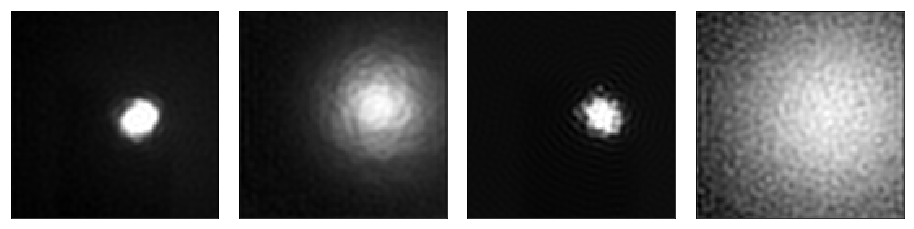

Training / Validation / Test sets sizes: 6400 / 800 / 800


In [82]:
# Importation
preproc = Preprocessor('roughness-depth')
imgs, labels = preproc.concatenate_dataset(paths=['./datasets/roughness/render_dataset_gray_r128_s96_n8000_rot005.npz'], grayscale=True)

# Image processing (this reduces the number of components in PCA)
imgs_processed = preproc.process_gray(imgs, radius=0.2)

# Splitting
x_tr_gray, y_tr_gray, x_val_gray, y_val_gray, x_te_gray, y_te_gray = preproc.split_custom(imgs_processed, labels)

Setup graph with 64 filters in 1st CL, 64 filters in 2nd CL and 256 neurons in fully-connected layer.

Finished epoch 1. Validation RMSE = 0.1079
Finished epoch 2. Validation RMSE = 0.0828
Finished epoch 3. Validation RMSE = 0.0660
Finished epoch 4. Validation RMSE = 0.0559
Finished epoch 5. Validation RMSE = 0.0536
Finished epoch 6. Validation RMSE = 0.0408
Finished epoch 7. Validation RMSE = 0.0365
Finished epoch 8. Validation RMSE = 0.0355
Finished (time: 330.8 sec).


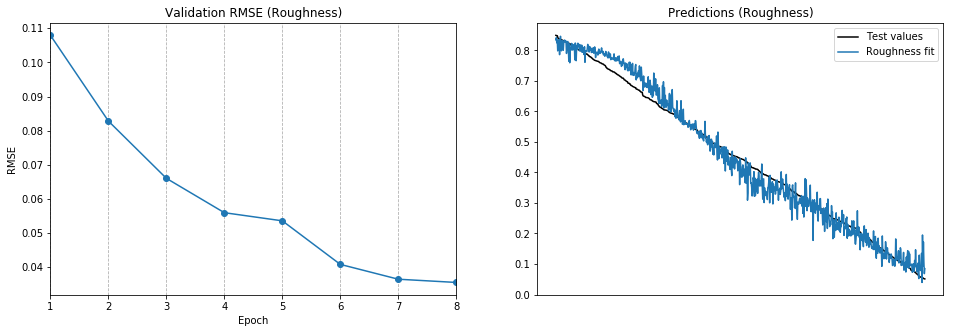

RMSE on test set: 0.03
Model saved in path: ./cache/cnn_model_Roughness.ckpt


In [83]:
# CNN roughness
gr_rough = CNN_Graph(f1=64, f2=64, rx=128, ry=128, rz=1)
runfit_cnn['Roughness'] = gr_rough.launchG('Roughness', 8, 0.001, 50, x_tr_gray, 
                                                   y_tr_gray[:,3], 
                                                   x_val_gray, 
                                                   y_val_gray[:,3], 
                                                   x_te_gray, 
                                                   y_te_gray[:,3])

### Texture depth CNN

Setup graph with 64 filters in 1st CL, 64 filters in 2nd CL and 256 neurons in fully-connected layer.

Finished epoch 1. Validation RMSE = 0.1333
Finished epoch 2. Validation RMSE = 0.1328
Finished epoch 3. Validation RMSE = 0.1334
Finished epoch 4. Validation RMSE = 0.1356
Finished (time: 206.6 sec).


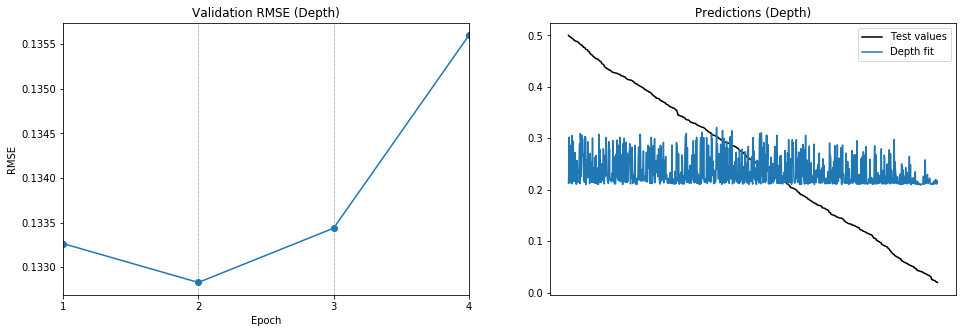

RMSE on test set: 0.13
Model saved in path: ./cache/cnn_model_Depth.ckpt


In [84]:
# CNN depth
gr_depth_128 = CNN_Graph(f1=64, f2=64, rx=128, ry=128, rz=1)
runfit_cnn['Depth'] = gr_depth_128.launchG('Depth', 4, 0.001, 50, x_tr_scale, 
                                                                  y_tr_scale[:,5], 
                                                                  x_val_scale, 
                                                                  y_val_scale[:,5], 
                                                                  x_te_scale, 
                                                                  y_te_scale[:,5])

### Texture scale CNN

Setup graph with 64 filters in 1st CL, 64 filters in 2nd CL and 256 neurons in fully-connected layer.

Finished epoch 1. Validation RMSE = 139.4393
Finished epoch 2. Validation RMSE = 130.8188
Finished epoch 3. Validation RMSE = 127.8256
Finished epoch 4. Validation RMSE = 124.0281
Finished (time: 203.1 sec).


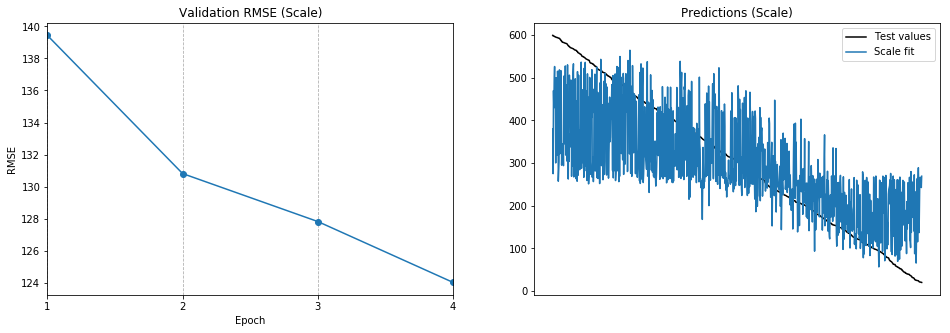

RMSE on test set: 118.23
Model saved in path: ./cache/cnn_model_Scale.ckpt


In [85]:
# CNN scale
gr_scale_128 = CNN_Graph(f1=64, f2=64, rx=128, ry=128, rz=1)
runfit_cnn['Scale'] = gr_scale_128.launchG('Scale', 4, 0.001, 50, x_tr_scale, 
                                                                  y_tr_scale[:,4], 
                                                                  x_val_scale, 
                                                                  y_val_scale[:,4], 
                                                                  x_te_scale, 
                                                                  y_te_scale[:,4])

### Summary: CNN

In [86]:
df_cnn = pd.DataFrame(runfit_cnn).transpose()
df_cnn.columns = ['method', 'RMSE (validation set)', 'RMSE (test set)']
df_cnn

method RMSE (validation set) RMSE (test set)
Depth        CNN                0.1356       0.0178861
Roughness    CNN              0.035505      0.00120536
Scale        CNN               124.028         13979.2

# Part 3: Predict properties of real set and shared test set

class Predictor(Preprocessor):
    - def __init__():
    - def grayize():
    - def resize():
    - def return_center_image():
    - def process_duplicate():
    - def return_prediction():
    
- Predicting settings for real materials (real set)
- Predicting settings for high resolution virtal materials (shared test set)

In [41]:
class Predictor(Preprocessor):
    # This class heritates from showsample(), process_rgb(), process_gray() and process_scale() from the Preprocessor class
    def __init__(self, title):
        Preprocessor.__init__(self, title)
        
    def grayize(self, imgs):
        # Converts images to grayscale
        gray_imgs = []
        for rgb in imgs:
            r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
            gray = 0.33*r +0.33*g+0.33*b
            gray_imgs.append(gray)
        gray_imgs = np.asarray(gray_imgs)

        return gray_imgs

    def resize(self, imgs, sizex, sizey):
        # Resizes images
        resized_imgs = []
        for img in imgs:  
            img = Image.fromarray(img.astype('uint8')).resize((sizex, sizey))
            img = np.asarray(img)/255
            resized_imgs.append(img)
        resized_imgs = np.asarray(resized_imgs)

        return resized_imgs 

    def return_center_image(self, imgs):
        # Returns the center part of images (10x zoom in)
        center_imgs = []
        for img in imgs:
            rx_im, ry_im = img.shape[0], img.shape[1]
            l1x, l2x = int(9/20*rx_im), int(9/20*ry_im)
            l1y, l2y = int(11/20*rx_im), int(11/20*ry_im)
            im_center = img[l1x:l1y, l2x:l2y]        
            center_imgs.append(im_center)
        center_imgs = np.asarray(center_imgs)
        center_imgs = self.grayize(center_imgs)
        
        return center_imgs
    
    def process_duplicate(self, input_imgs):
        # Performs image processing steps and returns suitable data for RGB, roughness, scale and depth predictions
        print('Raw images: ')
        self.showsample(np.asarray(input_imgs)/255, grayscale=False)
        
        # Resize
        resized_imgs = self.resize(input_imgs, 128, 128)
        
        # RGB data
        x_rgb = self.process_rgb(resized_imgs)
        
        # Convert to grayscale
        gray_imgs = self.grayize(resized_imgs)
        
        # Roughness (and depth) data
        x_rough = self.process_gray(gray_imgs)
        
        # Center images
        center_imgs = self.return_center_image(input_imgs)
        
        # Scale data
        x_scale =self.resize(center_imgs, 128, 128)
        print('Scale image:')
        self.showsample(x_scale, grayscale=True)
        x_fft = self.process_scale(x_scale, binarize=False, approach='fft_only')

        return x_rgb, x_rough, x_fft
    
    def return_prediction(self, estimator, x_data, limdown, limup):
        # Returns predictions
        pred = estimator.predict(x_data)
        pred[pred<limdown] = limdown
        pred[pred>limup]   = limup

        return pred

### Predicting settings for real materials (real set)

In [87]:
# Scale and depth baselines
scale_baseline = np.mean(y_tr_scale[:,4])
depth_baseline = np.mean(y_tr_scale[:,5])

print('scale baseline: ', scale_baseline)
print('depth baseline: ', depth_baseline)

scale baseline:  310.14513263673587
depth baseline:  0.26032194339430315


In [88]:
# Importation
x_real = []
for k in range(23):
    # Import image
    img_name = 'im{}.jpg'.format(str(k))
    im = np.asarray(Image.open('./real_samples/'+img_name))
    # Base image
    x_real.append(im)

Initialized:  real
Raw images: 


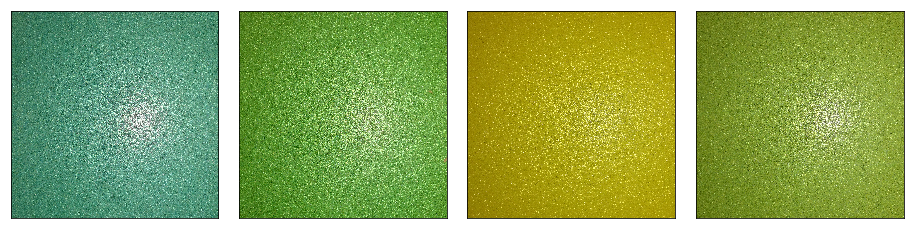

FFT color filter (image processing time: 0 sec.):


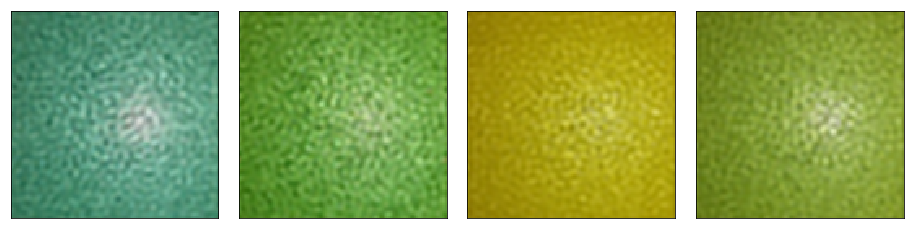

FFT grayscale filter (image processing time: 0 sec.):


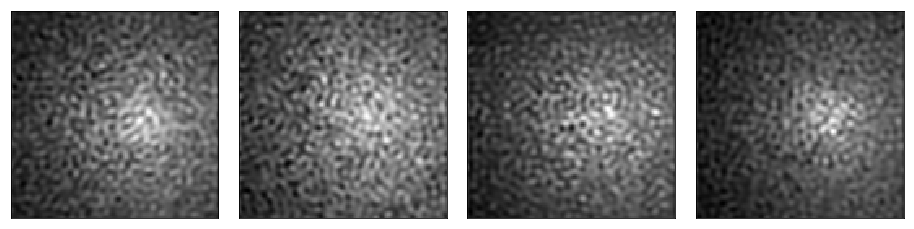

Scale image:


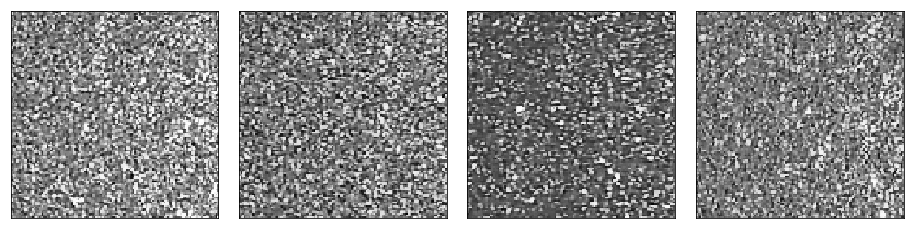

Raw FFT (image processing time: 0 sec.):


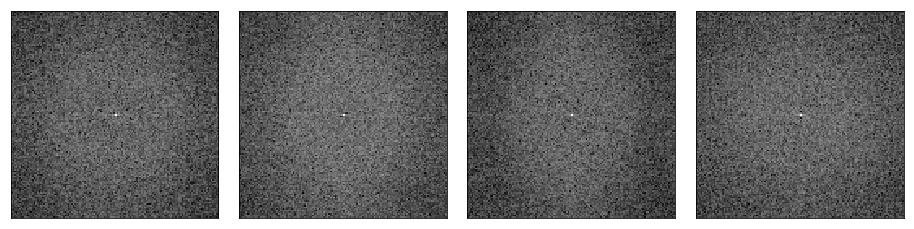

INFO:tensorflow:Restoring parameters from ./cache/cnn_model_Roughness.ckpt
Model restored.
Predictions overview:

        Red     Green      Blue  Roughness       Scale     Depth
0  0.367418  0.972194  0.693912   0.517436  310.145133  0.260322
1  0.539326  1.000000  0.063086   0.546520  310.145133  0.260322
2  1.000000  1.000000  0.000000   0.597848  310.145133  0.260322
3  0.820398  1.000000  0.011604   0.504268  310.145133  0.260322
4  1.000000  0.774617  0.000000   0.525305  310.145133  0.260322


In [89]:
# Predictor object
predictor = Predictor('real')

# Suitable data for predictions
x_rgb, x_rough, x_fft = predictor.process_duplicate(x_real)

# To store the predictions
dico_settings = {}
    
# Red / Green / Blue predictions
dico_settings['Red'] = predictor.return_prediction(df.loc['Red', 'estimator'], flatten(x_rgb[:,:,:,0]), 0, 1)
dico_settings['Green'] = predictor.return_prediction(df.loc['Green', 'estimator'], flatten(x_rgb[:,:,:,1]), 0, 1)
dico_settings['Blue'] = predictor.return_prediction(df.loc['Blue', 'estimator'], flatten(x_rgb[:,:,:,2]), 0, 1)

# Roughness CNN predictions
x_rough_cnn = x_rough.reshape(x_rough.shape[0], x_rough.shape[1], x_rough.shape[2], 1)
dico_settings['Roughness'] = gr_rough.return_prediction(x_rough_cnn, 0.05, 0.85)

# Roughness / depth classical predictions
#dico_settings['Roughness'] = return_prediction(df.loc['Roughness', 'estimator'], flatten(x_rough), 0.05, 0.85)

# Scale / Depth prerdictions
#dico_settings['Scale'] = predictor.return_prediction(df.loc['Scale', 'estimator'], flatten(x_fft), 20, 600)
dico_settings['Scale'] = scale_baseline
#dico_settings['Depth'] = predictor.return_prediction(df.loc['Depth', 'estimator'], flatten(x_fft), 0.02, 0.5)
dico_settings['Depth'] = depth_baseline

# Put everything in a dataframe
df_real = pd.DataFrame(data=dico_settings)
df_real = df_real[['Red', 'Green', 'Blue', 'Roughness', 'Scale', 'Depth']]
print('Predictions overview:\n')
print(df_real.head())

# Savings
sumup_real = df_real.values
dico_real = {'settings':sumup_real}
fname = 'C:\\Users\\mallo\\Unit5\\cache\\settings_real_complex.npz'
with open(fname, 'wb') as f:
    np.savez(fname, **dico_real, allow_pickle=False)
    
# Additional savings
xreal_dico = {'x_real_rgb':x_rgb, 'x_real_rough':x_rough, 'x_real_scale':x_fft}
fname = 'C:\\Users\\mallo\\Unit5\\cache\\x_real_complex.npz'
with open(fname, 'wb') as f:
    np.savez(fname, **xreal_dico, allow_pickle=False)

### Predicting settings for high resolution virtual materials (shared test set)

In [91]:
# Importation
def load_data(path, grayscale=False):
    
    with np.load(path) as render_data:
        dico_renders = dict(render_data.items())

    imgs_ = dico_renders['renders']
    imgs_[imgs_>1.0] = 1.0
    imgs_[imgs_<0.0] = 0.0

    labels_ = dico_renders['labels']
    
    return imgs_, labels_

x_test, labels_test = load_data(path='./datasets/render_dataset_shared_r1280_s128_n4.npz')
x_test = x_test*255

Initialized:  shared test
Raw images: 


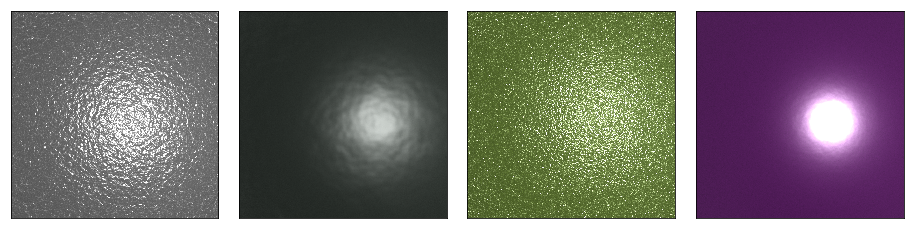

FFT color filter (image processing time: 0 sec.):


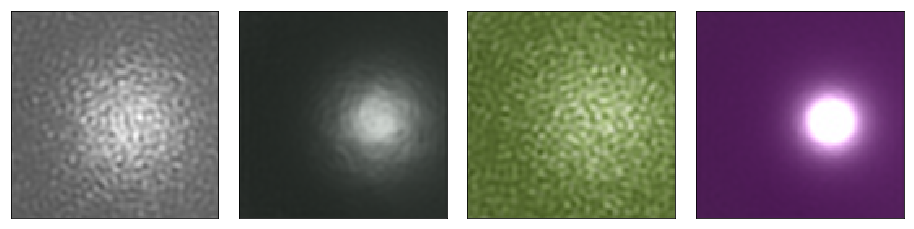

FFT grayscale filter (image processing time: 0 sec.):


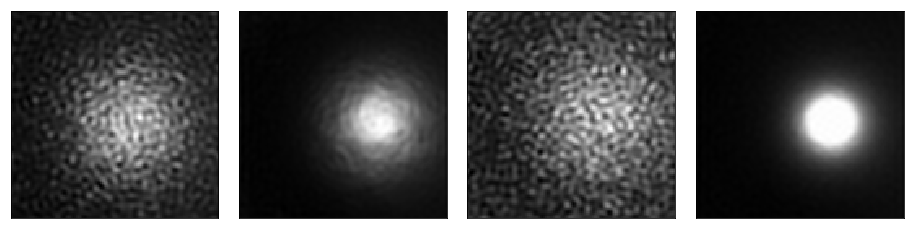

Scale image:


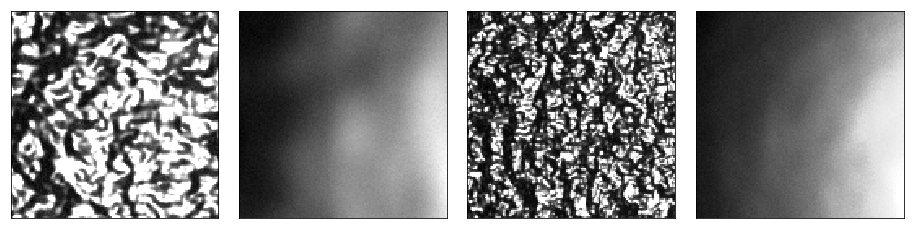

Raw FFT (image processing time: 0 sec.):


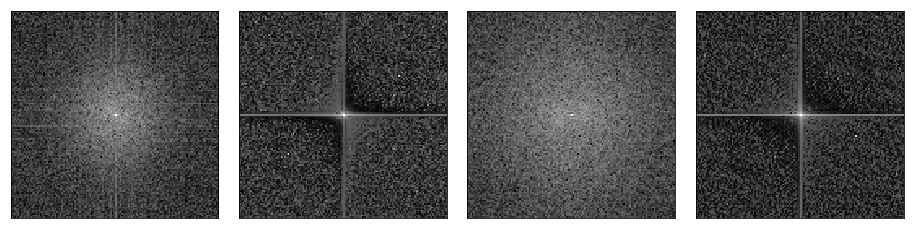

INFO:tensorflow:Restoring parameters from ./cache/cnn_model_Roughness.ckpt
Model restored.
Predictions overview:

        Red     Green      Blue  Roughness       Scale     Depth
0  0.647264  0.641081  0.641781   0.482236  310.145133  0.260322
1  0.145445  0.206506  0.159847   0.376439  310.145133  0.260322
2  0.545041  0.754438  0.138946   0.488590  310.145133  0.260322
3  0.654992  0.257744  0.720161   0.301823  310.145133  0.260322


In [92]:
# Predictor object
predictor = Predictor('shared test')

# Suitable data for predictions
x_rgb, x_rough, x_fft = predictor.process_duplicate(x_test)

# To store the predictions
dico_settings = {}
    
# Red / Green / Blue predictions
dico_settings['Red'] = predictor.return_prediction(df.loc['Red', 'estimator'], flatten(x_rgb[:,:,:,0]), 0, 1)
dico_settings['Green'] = predictor.return_prediction(df.loc['Green', 'estimator'], flatten(x_rgb[:,:,:,1]), 0, 1)
dico_settings['Blue'] = predictor.return_prediction(df.loc['Blue', 'estimator'], flatten(x_rgb[:,:,:,2]), 0, 1)

# Roughness CNN predictions
x_rough_cnn = x_rough.reshape(x_rough.shape[0], x_rough.shape[1], x_rough.shape[2], 1)
dico_settings['Roughness'] = gr_rough.return_prediction(x_rough_cnn, 0.05, 0.85)

# Roughness / depth classical predictions
#dico_settings['Roughness'] = return_prediction(df.loc['Roughness', 'estimator'], flatten(x_rough), 0.05, 0.85)

# Scale / Depth prerdictions
#dico_settings['Scale'] = predictor.return_prediction(df.loc['Scale', 'estimator'], flatten(x_fft), 20, 600)
dico_settings['Scale'] = scale_baseline
#dico_settings['Depth'] = predictor.return_prediction(df.loc['Depth', 'estimator'], flatten(x_fft), 0.02, 0.5)
dico_settings['Depth'] = depth_baseline

# Put everything in a dataframe
df_test = pd.DataFrame(data=dico_settings)
df_test = df_test[['Red', 'Green', 'Blue', 'Roughness', 'Scale', 'Depth']]
print('Predictions overview:\n')
print(df_test.head())

# Savings
sumup_test = df_test.values
dico_test = {'settings':sumup_test}
fname = 'C:\\Users\\mallo\\Unit5\\cache\\settings_test_complex.npz'
with open(fname, 'wb') as f:
    np.savez(fname, **dico_test, allow_pickle=False)
    
# Additional savings
xtest_dico = {'x_test_rgb':x_rgb, 'x_test_rough':x_rough, 'x_test_scale':x_fft}
fname = 'C:\\Users\\mallo\\Unit5\\cache\\x_test_complex.npz'
with open(fname, 'wb') as f:
    np.savez(fname, **xtest_dico, allow_pickle=False)